📌 TASK 1: Web Scraping

                                      Header/Section  \
0  Automatic and Smart Pet Feeder Market - By Pet...   
1         Automatic and Smart Pet Feeder Market Size   
2                                   COVID-19 Impacts   
3       Automatic and Smart Pet Feeder Market Trends   
4  Automatic and Smart Pet Feeder Pet Market Anal...   

                                           Paragraph  
0                                  Download Free PDF  
1  Automatic And Smart Pet Feeder Market size was...  
2                                                     
3  As pet owners embrace digitalization and smart...  
4  Pets have become an important part of families...  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📌 TASK 2: Exploratory Data Analysis

Total sections scraped: 11
                                      Header/Section  \
0  Automatic and Smart Pet Feeder Market - By Pet...   
1         Automatic and Smart Pet Feeder Market Size   
2                                   COVID-19 Impacts   

                                           Paragraph  
0                                  Download Free PDF  
1  Automatic And Smart Pet Feeder Market size was...  
2                                                NaN  


/tmp/ipython-input-7-3815536450.py:66: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


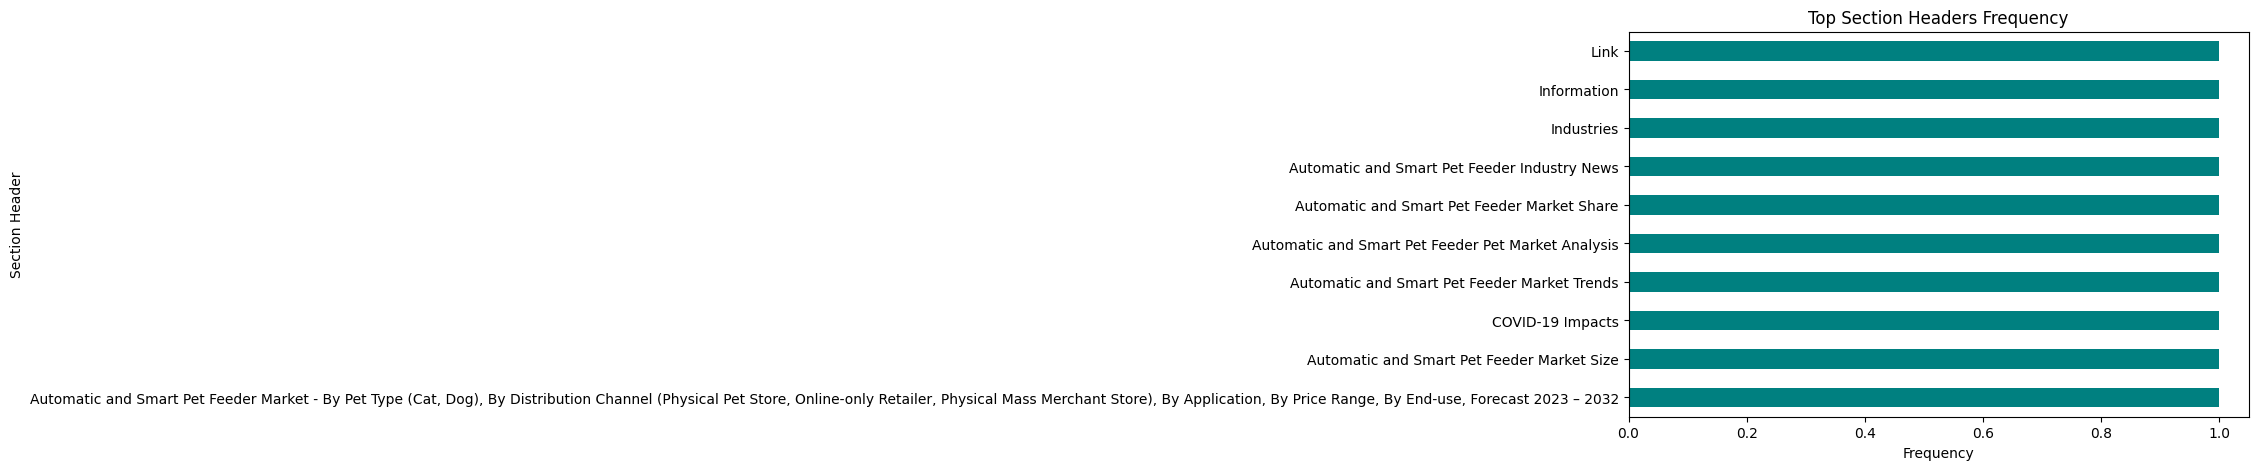


📌 TASK 3: Data Visualization – Market Share



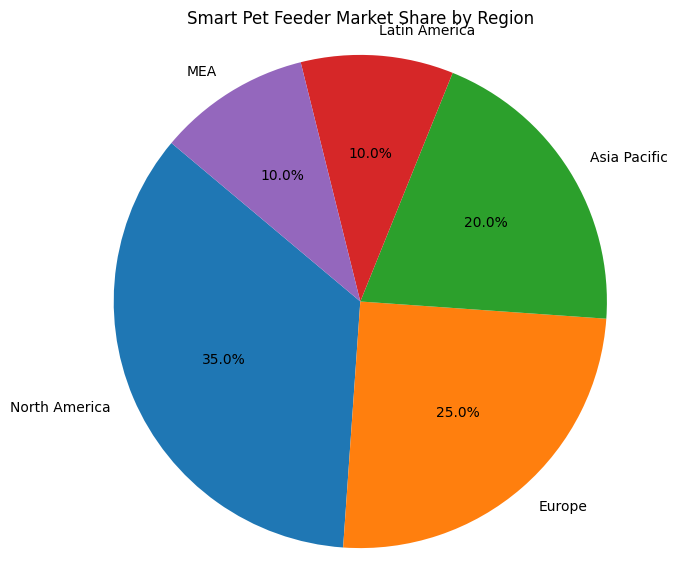


📌 TASK 4: Sentiment Analysis (With Visualizations)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

                                      Header/Section  Polarity Sentiment
0  Automatic and Smart Pet Feeder Market - By Pet...  0.400000  Positive
1         Automatic and Smart Pet Feeder Market Size  0.357143  Positive
2                                   COVID-19 Impacts  0.000000   Neutral
3       Automatic and Smart Pet Feeder Market Trends  0.168214  Positive
4  Automatic and Smart Pet Feeder Pet Market Anal...  0.120000  Positive
5        Automatic and Smart Pet Feeder Market Share -0.010045  Negative
6       Automatic and Smart Pet Feeder Industry News  0.153571  Positive
7                                         Industries  0.245040  Positive
8                                        Information  0.046429  Positive
9                                               Link  0.000000   Neutral


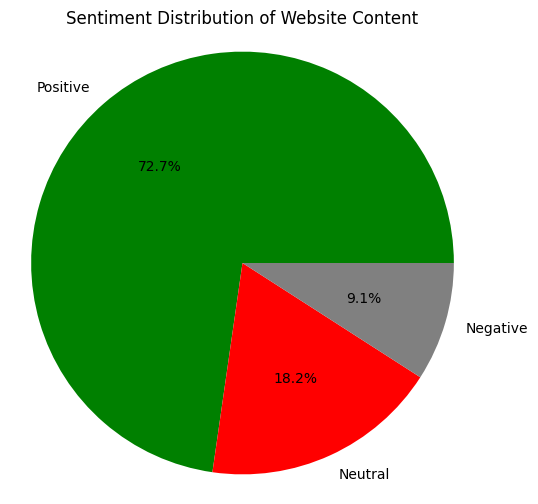

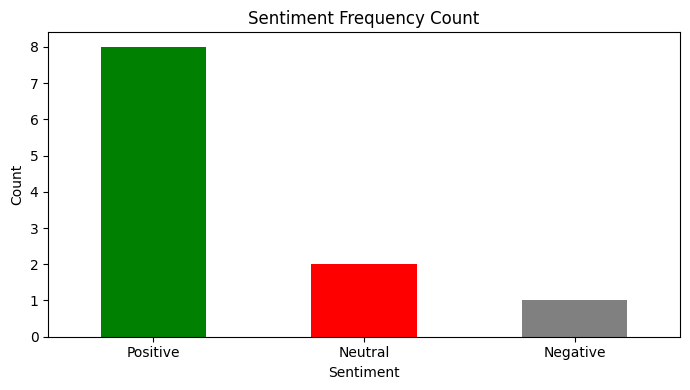

In [ ]:
# STEP 1: Upload Local CSV
from google.colab import files
uploaded = files.upload()

# STEP 2: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests

# STEP 3: Load & Clean Local CSV Data
csv_df = pd.read_csv('SMART_MULTIPET_FEEDING_SYSTEM.csv')
csv_df.replace("-", np.nan, inplace=True)
csv_df['timestamp'] = pd.to_datetime(csv_df['timestamp'])
csv_df['servo_delay (s)'] = pd.to_numeric(csv_df['servo_delay (s)'], errors='coerce')
csv_df['stepper_steps'] = pd.to_numeric(csv_df['stepper_steps'], errors='coerce')
csv_df['bowl_no'] = pd.to_numeric(csv_df['bowl_no'], errors='coerce')
csv_df['weight_before'] = pd.to_numeric(csv_df['weight_before'], errors='coerce')
csv_df['weight_after'] = pd.to_numeric(csv_df['weight_after'], errors='coerce')
csv_df['weight_dispensed'] = csv_df['weight_after'] - csv_df['weight_before']

# STEP 4: Fetch Live Data from ThingSpeak
channel_id = 'YOUR_CHANNEL_ID'  # 🔁 Replace this
url = f"https://api.thingspeak.com/channels/{channel_id}/feeds.json?results=100"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    feeds = data['feeds']
    ts_df = pd.DataFrame(feeds)
    ts_df['created_at'] = pd.to_datetime(ts_df['created_at'])
    ts_df['field1'] = pd.to_numeric(ts_df['field1'], errors='coerce')  # container weight
    ts_df['field2'] = pd.to_numeric(ts_df['field2'], errors='coerce')  # bowl number
    ts_df['field3'] = ts_df['field3']  # RFID tag
    ts_df['field4'] = pd.to_numeric(ts_df['field4'], errors='coerce')  # servo delay
    ts_df['field5'] = pd.to_numeric(ts_df['field5'], errors='coerce')  # stepper steps

    # Optional RFID to Pet Name Mapping
    rfid_map = {
        '123ABC': 'Tommy',
        '456DEF': 'Bella',
        '789XYZ': 'Oscar'
    }
    ts_df['pet_name'] = ts_df['field3'].map(rfid_map)
    ts_df.rename(columns={
        'field1': 'container_weight',
        'field2': 'bowl_no',
        'field4': 'servo_delay',
        'field5': 'stepper_steps'
    }, inplace=True)

    print("✅ Live sensor data loaded from ThingSpeak.\n")
else:
    print("❌ Failed to load live data from ThingSpeak:", response.status_code)
    ts_df = pd.DataFrame()  # Empty fallback

# STEP 5: Alert Based on Current Container Weight
if not ts_df.empty and ts_df['container_weight'].dropna().size > 0:
    latest_weight = ts_df['container_weight'].dropna().iloc[-1]
    if latest_weight < 20:
        print(f"⚠️ ALERT: Current container weight is {latest_weight}g. Please refill!")
    else:
        print(f"✅ Container weight is healthy: {latest_weight}g")

# STEP 6: Analytics - Local Data

# 1. Feeding Count per Pet
print("\n📊 Feeding Count per Pet:")
print(csv_df['pet_name'].value_counts())

# 2. Total Weight Dispensed per Pet
print("\n📦 Total Weight Dispensed per Pet:")
print(csv_df.groupby('pet_name')['weight_dispensed'].sum())

# 3. Average Servo Delay and Stepper Steps
print("\n⚙️ Average Servo Delay and Stepper Steps:")
print(csv_df.groupby('pet_name')[['servo_delay (s)', 'stepper_steps']].mean())

# 4. Bowl Usage Stats
print("\n🍽️ Bowl Usage per Pet:")
print(csv_df.groupby(['pet_name', 'bowl_no']).size().unstack(fill_value=0))

# 5. Feeding Time Distribution
csv_df['hour'] = csv_df['timestamp'].dt.hour
sns.countplot(data=csv_df, x='hour', hue='pet_name')
plt.title("🕒 Feeding Hours by Pet")
plt.xlabel("Hour of Day")
plt.ylabel("Feeding Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# STEP 7: Plot Container Weight Over Time (Live Data)
if not ts_df.empty:
    plt.figure(figsize=(12, 5))
    plt.plot(ts_df['created_at'], ts_df['container_weight'], marker='o', color='teal')
    plt.title("📉 Container Weight Over Time (ThingSpeak)")
    plt.xlabel("Timestamp")
    plt.ylabel("Container Weight (g)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# STEP 8: Optional Merge - Live vs Local Comparison
if not ts_df.empty:
    merged_df = pd.merge_asof(
        csv_df.sort_values('timestamp'),
        ts_df.sort_values('created_at'),
        left_on='timestamp',
        right_on='created_at',
        direction='nearest',
        tolerance=pd.Timedelta('2min')
    )
    print("\n🔗 Combined Local + Live View:")
    print(merged_df[['timestamp', 'pet_name', 'bowl_no_x', 'weight_dispensed', 'container_weight']].head())
